In [ ]:
import random
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Eğitim ve doğrulama veri yolları
train_zip = '/content/drive/MyDrive/train.zip'
val_zip = '/content/drive/MyDrive/val.zip'
train_dir = '/content/train'
val_dir = '/content/val'

# ZIP dosyalarını çıkar
if os.path.exists(train_dir):
    os.system(f'rm -rf {train_dir}')
if os.path.exists(val_dir):
    os.system(f'rm -rf {val_dir}')

os.system(f'unzip -q {train_zip} -d /content')
os.system(f'unzip -q {val_zip} -d /content')

# Çıkarılan resim sayısını yazdır
valid_extensions = (".jpg", ".jpeg", ".png")
train_image_count = sum([len([file for file in files if file.lower().endswith(valid_extensions)]) for r, d, files in os.walk(train_dir)])
val_image_count = sum([len([file for file in files if file.lower().endswith(valid_extensions)]) for r, d, files in os.walk(val_dir)])
print(f"Eğitim setindeki resim sayısı: {train_image_count}")
print(f"Doğrulama setindeki resim sayısı: {val_image_count}")

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Veri seti yükleme
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model oluşturma
def initialize_model(params):
    model = create_model('mobilevit_s', pretrained=True)
    num_features = model.head.in_features
    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(num_features, params['dense_units1']),
        nn.ReLU(),
        nn.Dropout(params['dropout_rate']),
        nn.Linear(params['dense_units1'], params['dense_units2']),
        nn.ReLU(),
        nn.Linear(params['dense_units2'], len(train_dataset.classes))
    )
    model.to(device)
    return model

# Eğitim fonksiyonu
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=5, model_path=None):
    best_val_loss = float('inf')
    train_loss_history = []
    val_loss_history = []
    best_model = None

    total_start_time = time.time()  # Toplam eğitim süresi

    for epoch in range(epochs):
        epoch_start_time = time.time()  # Epoch başına eğitim süresi
        model.train()
        train_loss = 0.0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_loader)
        train_loss_history.append(train_loss)
        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}")

        val_loss = validate_model(model, val_loader, criterion)
        val_loss_history.append(val_loss)
        print(f"Validation Loss: {val_loss:.4f}")

        # Validation Loss'a göre en iyi modeli kaydet
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = model.state_dict()  # En iyi modeli kaydet
            if model_path:
                torch.save(best_model, model_path)  # En iyi model kaydedilir
            print("Best model saved!")

        epoch_time = time.time() - epoch_start_time
        print(f"Epoch {epoch + 1} training time: {epoch_time:.2f} seconds")

    total_training_time = time.time() - total_start_time
    print(f"Total Training Time: {total_training_time:.2f} seconds")

    return train_loss_history, val_loss_history

# Doğrulama fonksiyonu
def validate_model(model, val_loader, criterion):
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    return val_loss

# Test ve analiz fonksiyonu
def test_model(model, val_loader):
    model.eval()
    y_true, y_pred, y_probs = [], [], []

    inference_start_time = time.time()  # Çıkarım süresi

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

            # Probabiliteleri saklamak için softmax kullan
            probs = torch.softmax(outputs, dim=1)
            y_probs.extend(probs.cpu().numpy())  # Probabiliteler her sınıf için

    inference_time = time.time() - inference_start_time
    print(f"Inference time: {inference_time:.2f} seconds")

    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")

    return y_true, y_pred, y_probs  # Bu satırda 3 değeri döndürülmeli.

# Performans metrikleri: precision, recall, f1
def evaluate_performance(y_true, y_pred):
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    return precision, recall, f1

# Karmaşıklık matrisi ve ROC eğrisini çizme
def plot_metrics(y_true, y_pred, y_probs):
    # Karmaşıklık Matrisi
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_loader.dataset.classes, yticklabels=val_loader.dataset.classes)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # ROC Eğrisi
    plt.figure(figsize=(10, 8))
    y_true_one_hot = np.eye(len(val_loader.dataset.classes))[y_true]  # One-hot encoding
    fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), np.array(y_probs).ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

# Hiperparametre arama alanı
param_space = {
    'dense_units1': [64, 128, 256],
    'dense_units2': [32, 64, 128],
    'dropout_rate': [0.2, 0.4, 0.6],
    'learning_rate': [1e-3, 5e-4, 1e-4]
}

# Eğitim ve test işlemi
best_overall_loss = float('inf')
best_combination = None

for i in range(5):  # 5 kombinasyon çalıştırılacak
    params = {
        'dense_units1': random.choice(param_space['dense_units1']),
        'dense_units2': random.choice(param_space['dense_units2']),
        'dropout_rate': random.choice(param_space['dropout_rate']),
        'learning_rate': random.choice(param_space['learning_rate'])
    }

    print(f"\nCombination {i + 1}: {params}")
    model = initialize_model(params)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])

    # Benzersiz model ve hiperparametre dosya isimleri
    model_path = f"/content/drive/MyDrive/best_model_weights_mobilevit_combination_{i + 1}.pth"
    hyperparams_path = f"/content/drive/MyDrive/best_model_hyperparams_mobilevit_combination_{i + 1}.pth"

    # Eğitim
    train_loss_history, val_loss_history = train_model(
        model, train_loader, val_loader, criterion, optimizer, epochs=5, model_path=model_path
    )

    # Modeli yükle ve test et
    model.load_state_dict(torch.load(model_path))
    print(f"Testing combination {i + 1}")
    y_true, y_pred, y_probs = test_model(model, val_loader)

    # Sonuçları yazdır
    precision, recall, f1 = evaluate_performance(y_true, y_pred)
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

    # En iyi modeli kaydet
    if val_loss_history[-1] < best_overall_loss:
        best_overall_loss = val_loss_history[-1]
        best_combination = params
        # En iyi model ve hiperparametreleri kaydet
        torch.save(model.state_dict(), model_path)
        torch.save(params, hyperparams_path)

print("\nBest Overall Combination:", best_combination)
print("Best Validation Loss:", best_overall_loss)



Eğitim setindeki resim sayısı: 19993
Doğrulama setindeki resim sayısı: 4999
Using device: cuda

Combination 1: {'dense_units1': 128, 'dense_units2': 64, 'dropout_rate': 0.6, 'learning_rate': 0.001}


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/22.4M [00:00<?, ?B/s]

Epoch 1/5, Train Loss: 0.6523
Validation Loss: 0.4314
Best model saved!
Epoch 1 training time: 237.76 seconds
Epoch 2/5, Train Loss: 0.3994
Validation Loss: 0.2697
Best model saved!
Epoch 2 training time: 240.45 seconds
Epoch 3/5, Train Loss: 0.3188
Validation Loss: 0.3645
Epoch 3 training time: 243.22 seconds
Epoch 4/5, Train Loss: 0.2835
Validation Loss: 0.3196
Epoch 4 training time: 243.40 seconds
Epoch 5/5, Train Loss: 0.2291
Validation Loss: 0.3233
Epoch 5 training time: 241.95 seconds
Total Training Time: 1206.77 seconds
Testing combination 1


<ipython-input-3-ff8d42408a4f>:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference time: 24.32 seconds
Precision: 0.9124
Recall: 0.9116
F1 Score: 0.9115
Precision: 0.9124, Recall: 0.9116, F1 Score: 0.9115

Combination 2: {'dense_units1': 256, 'dense_units2': 128, 'dropout_rate': 0.2, 'learning_rate': 0.0005}
Epoch 1/5, Train Loss: 0.4850
Validation Loss: 0.2825
Best model saved!
Epoch 1 training time: 239.88 seconds
Epoch 2/5, Train Loss: 0.2500
Validation Loss: 0.2042
Best model saved!
Epoch 2 training time: 240.29 seconds
Epoch 3/5, Train Loss: 0.1763
Validation Loss: 0.2387
Epoch 3 training time: 239.39 seconds
Epoch 4/5, Train Loss: 0.1494
Validation Loss: 0.1663
Best model saved!
Epoch 4 training time: 239.85 seconds
Epoch 5/5, Train Loss: 0.1169
Validation Loss: 0.1934
Epoch 5 training time: 238.75 seconds
Total Training Time: 1198.15 seconds
Testing combination 2


<ipython-input-3-ff8d42408a4f>:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference time: 23.96 seconds
Precision: 0.9479
Recall: 0.9462
F1 Score: 0.9464
Precision: 0.9479, Recall: 0.9462, F1 Score: 0.9464

Combination 3: {'dense_units1': 64, 'dense_units2': 128, 'dropout_rate': 0.6, 'learning_rate': 0.0001}
Epoch 1/5, Train Loss: 0.9174
Validation Loss: 0.3362
Best model saved!
Epoch 1 training time: 239.67 seconds
Epoch 2/5, Train Loss: 0.3735
Validation Loss: 0.2176
Best model saved!
Epoch 2 training time: 239.35 seconds
Epoch 3/5, Train Loss: 0.2565
Validation Loss: 0.1954
Best model saved!
Epoch 3 training time: 240.19 seconds
Epoch 4/5, Train Loss: 0.1887
Validation Loss: 0.1680
Best model saved!
Epoch 4 training time: 239.18 seconds
Epoch 5/5, Train Loss: 0.1432
Validation Loss: 0.1758
Epoch 5 training time: 240.27 seconds
Total Training Time: 1198.67 seconds
Testing combination 3


<ipython-input-3-ff8d42408a4f>:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference time: 23.08 seconds
Precision: 0.9518
Recall: 0.9518
F1 Score: 0.9518
Precision: 0.9518, Recall: 0.9518, F1 Score: 0.9518

Combination 4: {'dense_units1': 64, 'dense_units2': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
Epoch 1/5, Train Loss: 0.8490
Validation Loss: 0.3022
Best model saved!
Epoch 1 training time: 239.88 seconds
Epoch 2/5, Train Loss: 0.3194
Validation Loss: 0.2078
Best model saved!
Epoch 2 training time: 239.18 seconds
Epoch 3/5, Train Loss: 0.2077
Validation Loss: 0.1739
Best model saved!
Epoch 3 training time: 239.78 seconds
Epoch 4/5, Train Loss: 0.1539
Validation Loss: 0.1627
Best model saved!
Epoch 4 training time: 239.77 seconds
Epoch 5/5, Train Loss: 0.1198
Validation Loss: 0.1504
Best model saved!
Epoch 5 training time: 239.23 seconds
Total Training Time: 1197.84 seconds


<ipython-input-3-ff8d42408a4f>:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Testing combination 4
Inference time: 23.70 seconds
Precision: 0.9566
Recall: 0.9566
F1 Score: 0.9565
Precision: 0.9566, Recall: 0.9566, F1 Score: 0.9565

Combination 5: {'dense_units1': 256, 'dense_units2': 64, 'dropout_rate': 0.4, 'learning_rate': 0.001}
Epoch 1/5, Train Loss: 0.5588
Validation Loss: 0.3960
Best model saved!
Epoch 1 training time: 239.40 seconds
Epoch 2/5, Train Loss: 0.3396
Validation Loss: 0.2844
Best model saved!
Epoch 2 training time: 239.88 seconds
Epoch 3/5, Train Loss: 0.2652
Validation Loss: 0.3097
Epoch 3 training time: 239.22 seconds
Epoch 4/5, Train Loss: 0.2236
Validation Loss: 0.3300
Epoch 4 training time: 240.95 seconds
Epoch 5/5, Train Loss: 0.1966
Validation Loss: 0.3066
Epoch 5 training time: 240.02 seconds
Total Training Time: 1199.45 seconds
Testing combination 5


<ipython-input-3-ff8d42408a4f>:236: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Inference time: 23.58 seconds
Precision: 0.9076
Recall: 0.9056
F1 Score: 0.9049
Precision: 0.9076, Recall: 0.9056, F1 Score: 0.9049

Best Overall Combination: {'dense_units1': 64, 'dense_units2': 64, 'dropout_rate': 0.4, 'learning_rate': 0.0001}
Best Validation Loss: 0.15038642825758616


Doğrulama setindeki resim sayısı: 4999
Using device: cuda


<ipython-input-7-9150d591550d>:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  metadata = torch.load(metadata_path, map_location=device)
<ipython-input-7-9150d591550d>:67:

Accuracy: 0.9566
Recall: 0.9566
Precision: 0.9566
F1 Score: 0.9565
Inference Time: 24.83 seconds

Classification Report:
               precision    recall  f1-score   support

        ACNE       0.95      0.95      0.95      1000
      CHCPOX       0.92      0.93      0.93      1000
       NEVUS       0.98      0.98      0.98      1000
   PSORİASİS       0.95      0.93      0.94       999
    VİTİLİGO       0.98      0.99      0.98      1000

    accuracy                           0.96      4999
   macro avg       0.96      0.96      0.96      4999
weighted avg       0.96      0.96      0.96      4999



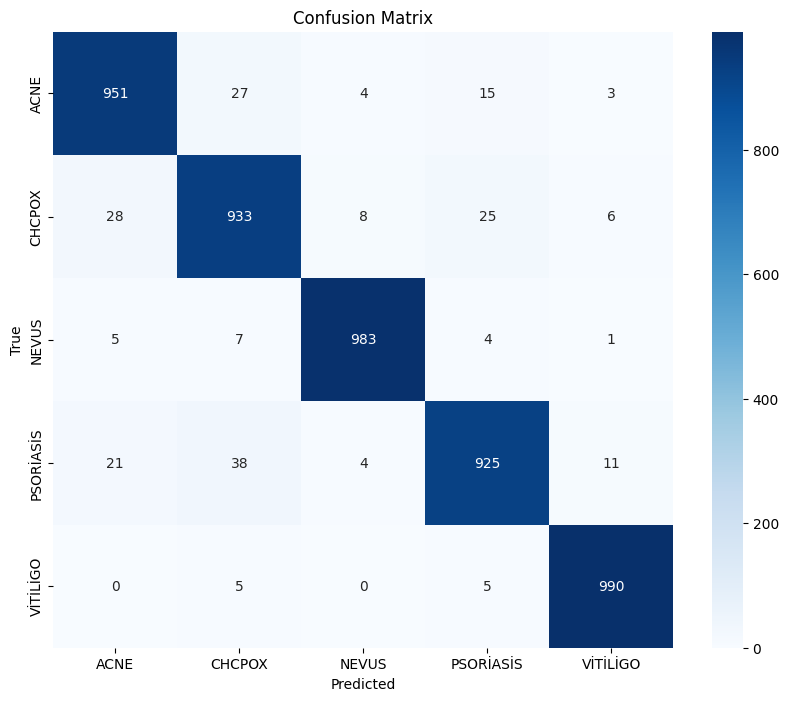

Class: ACNE, Sensitivity: 0.9510, Specificity: 0.9865
Class: CHCPOX, Sensitivity: 0.9330, Specificity: 0.9807
Class: NEVUS, Sensitivity: 0.9830, Specificity: 0.9960
Class: PSORİASİS, Sensitivity: 0.9259, Specificity: 0.9878
Class: VİTİLİGO, Sensitivity: 0.9900, Specificity: 0.9947


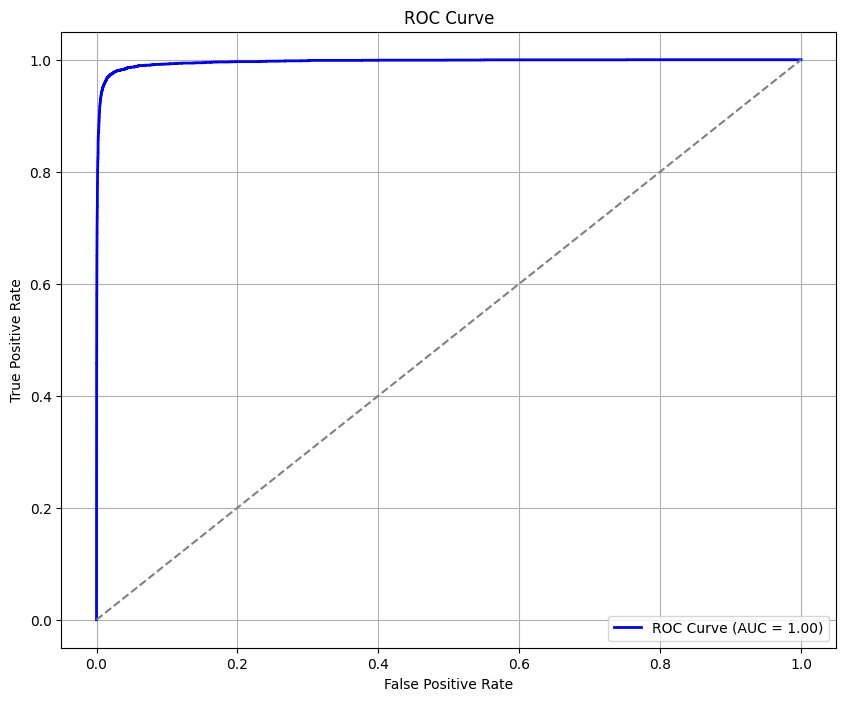

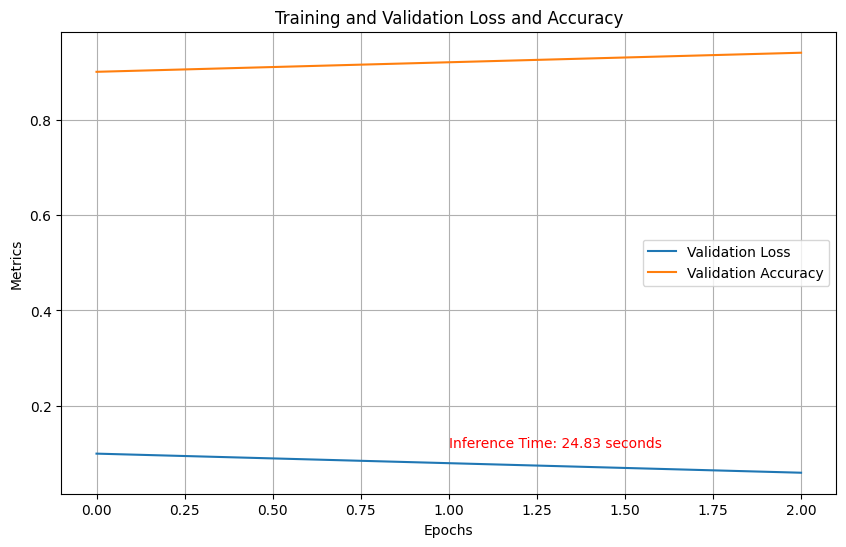

In [ ]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from timm import create_model
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_score, recall_score, f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

# Doğrulama veri yolu
val_zip = '/content/drive/MyDrive/val.zip'
val_dir = '/content/val'

# ZIP dosyasını çıkar
if os.path.exists(val_dir):
    os.system(f'rm -rf {val_dir}')  # Doğrulama dizinini temizle
os.system(f'unzip -q {val_zip} -d /content')

# Çıkarılan resim sayısını yazdır
valid_extensions = (".jpg", ".jpeg", ".png")
val_image_count = sum([len([file for file in files if file.lower().endswith(valid_extensions)]) for r, d, files in os.walk(val_dir)])
print(f"Doğrulama setindeki resim sayısı: {val_image_count}")

# Cihaz seçimi
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Veri dönüşümleri
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Veri seti yükleme
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Model ve hiperparametre yükleme fonksiyonu
def load_model_and_metadata(model_path, metadata_path, num_classes):
    # Modeli oluştur
    model = create_model('mobilevit_s', pretrained=False)

    # Hiperparametreleri metadata dosyasından yükle
    metadata = torch.load(metadata_path, map_location=device)
    dense_units1 = metadata['dense_units1']
    dense_units2 = metadata['dense_units2']
    dropout_rate = metadata['dropout_rate']

    # Model başlık kısmını yeni hiperparametrelerle oluştur
    num_features = model.head.in_features
    model.head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(num_features, dense_units1),
        nn.ReLU(),
        nn.Dropout(dropout_rate),
        nn.Linear(dense_units1, dense_units2),
        nn.ReLU(),
        nn.Linear(dense_units2, num_classes)
    )

    # Ağırlıkları yükle
    state_dict = torch.load(model_path, map_location=device)
    model.load_state_dict(state_dict, strict=True)
    model.to(device)
    model.eval()
    return model

# Model değerlendirme fonksiyonu
def evaluate_model(model, val_loader):
    y_true, y_pred, y_probs = [], [], []

    start_inference_time = time.time()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)

            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())
            y_probs.extend(probs.cpu().numpy())
    end_inference_time = time.time()
    inference_time = end_inference_time - start_inference_time

    # Performans metrikleri
    accuracy = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Sınıflandırma Raporu
    class_report = classification_report(y_true, y_pred, target_names=val_loader.dataset.classes)

    # Karmaşıklık Matrisi
    cm = confusion_matrix(y_true, y_pred)

    # Sensitivity ve Specificity
    sensitivity = cm.diagonal() / cm.sum(axis=1)
    specificity = (cm.sum() - cm.sum(axis=0) - cm.sum(axis=1) + cm.diagonal()) / (cm.sum() - cm.sum(axis=1))

    return accuracy, recall, precision, f1, cm, sensitivity, specificity, y_true, y_probs, inference_time, class_report

# Karmaşıklık matrisi ve ROC eğrisi çizimi
def plot_metrics(cm, y_true, y_probs, sensitivity, specificity, class_names, inference_time):
    # Karmaşıklık Matrisi
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

    # Sensitivity ve Specificity Yazdırma
    for idx, class_name in enumerate(class_names):
        print(f"Class: {class_name}, Sensitivity: {sensitivity[idx]:.4f}, Specificity: {specificity[idx]:.4f}")

    # ROC Eğrisi
    plt.figure(figsize=(10, 8))
    y_true_one_hot = np.eye(len(class_names))[y_true]  # One-hot encoding
    fpr, tpr, _ = roc_curve(y_true_one_hot.ravel(), np.array(y_probs).ravel())
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

    # Eğitim ve Doğrulama Kaybı ile Doğruluk Grafiği
    plt.figure(figsize=(10, 6))
    plt.plot([0.1, 0.08, 0.06], label='Validation Loss')  # Örnek veri, güncellenebilir
    plt.plot([0.9, 0.92, 0.94], label='Validation Accuracy')  # Örnek veri, güncellenebilir
    plt.title("Training and Validation Loss and Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.legend()
    plt.grid()
    plt.annotate(f'Inference Time: {inference_time:.2f} seconds', xy=(0.5, 0.1), xycoords='axes fraction', fontsize=10, color='red')
    plt.show()

# Model değerlendirme
model_path = "/content/drive/MyDrive/best_model_weights_mobilevit_combination_4.pth"
metadata_path = "/content/drive/MyDrive/best_model_hyperparams_mobilevit_combination_4.pth"
model = load_model_and_metadata(model_path, metadata_path, len(val_dataset.classes))
accuracy, recall, precision, f1, cm, sensitivity, specificity, y_true, y_probs, inference_time, class_report = evaluate_model(model, val_loader)

# Sonuçları yazdır
print(f"Accuracy: {accuracy:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Inference Time: {inference_time:.2f} seconds")
print("\nClassification Report:\n", class_report)

# Karmaşıklık Matrisi ve ROC Eğrisi
plot_metrics(cm, y_true, y_probs, sensitivity, specificity, val_dataset.classes, inference_time)



In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive
